In [108]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import time
import neal
import dimod
simulated_sampler = neal.SimulatedAnnealingSampler()

In [139]:
def csv_to_matrix(file_name):
    dimension = len(np.genfromtxt(file_name)) - 1
    rows = np.array([element[0] for element in pd.read_csv(file_name, delimiter=';', usecols=[0]).to_numpy()])
    matrix = np.genfromtxt(file_name, delimiter=';', skip_header=1, usecols = range(1,dimension+1))
    return(rows, matrix)

def load_mapping(file_name):
    frame = pd.read_csv(file_name, delimiter=';')
    class_to_number = {
        "Approved": 1,
        "Preclinical": 0,
        "Withdrawn": -1
    }
    dictionary = {key: class_to_number[val] for key, val in frame.set_index('ROWID')['Class'].to_dict().items()}
    return(frame, dictionary)

def cyclic_permutate_array(arr,n):
    return(arr[len(arr)-n:] + arr[:len(arr)-n])

def distance_from_2Dpoints(points):
    n = len(points)
    d = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            d[i,j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return(d)

def make_QUBO_upper_triangle(Q):
    Q = np.array(Q)
    return(np.transpose(Q - np.triu(Q)) + np.triu(Q))

def import_points(file_name):
    points = np.genfromtxt(file_name, delimiter = ',')
    return(points)

def cSVM(vectors, labels, upper_bound, kernel=1, solver='CPLEX', time_limit=0):
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if solver == 'CPLEX':
        model = pyo.ConcreteModel()
        model.points = pyo.RangeSet(0,N-1)
        model.dims = pyo.RangeSet(0,d-1)
        #model.x = pyo.Param(model.points, model.dims, within=pyo.Reals, initialize={(p,dim): vectors[p,dim] for p in range(N) for dim in range(d)})
        model.t = pyo.Param(model.points, within={-1,+1}, initialize=labels)
        model.C = pyo.Param(within=pyo.NonNegativeReals, initialize=upper_bound)
        model.kernel_terms = pyo.Param(model.points, model.points, within=pyo.Reals, initialize={(n,m): kernel(vectors[n],vectors[m]) for n in range(N) for m in range(N)})
        model.alpha = pyo.Var(model.points, within=pyo.NonNegativeReals, bounds=(0,model.C))
        model.balance = pyo.Constraint(expr=pyo.summation(model.t,model.alpha) == 0)
        model.obj = pyo.Objective(rule=lambda model: sum(sum(model.alpha[n]*model.alpha[m]*model.t[n]*model.t[m]*model.kernel_terms[n,m] for m in model.points) - model.alpha[n] for n in model.points))
        instance = model.create_instance()
        opt = pyo.SolverFactory('cplex', tee=False)
        if time_limit != 0:
            opt.options['timelimit'] = time_limit
        results = opt.solve(instance)
        objective = pyo.value(instance.obj)
        alpha = np.array([pyo.value(instance.alpha[n]) for n in instance.points])
        f = decision_function(vectors, labels, upper_bound, kernel, alpha)
    return(objective, alpha, f)

def qSVM(vectors, labels, base, num_encoding, penalty=True, kernel=1, solver='SA', shots=100, time_limit=0, samples=20):
    # Argument 'upperbound' in cSVM corresponds to sum_{k=0}^{num_encoding-1} base^k
    B = base
    K = num_encoding
    N = len(vectors)
    d = len(vectors[0])
    if isinstance(kernel, (int, float)): # if a number was given, use gaussian kernel
        kernel = gauss_kernel(kernel)
    if penalty == True:
        1 ### set standard value
    def sampleset_to_alphas(sampleset, samples):
        filtered_sampleset = sampleset.filter(lambda sample: any(np.array([sum(sample.sample[K*n+k] for k in range(K)) not in [0,K] for n in range(N)]))) # filter sampleset by found support vectors
        alphas = np.array([[sum(B**k * sample[K*n+k] for k in range(K)) for n in range(N)] for sample in list(filtered_sampleset)[:samples]])
        objectives = filtered_sampleset.data_vectors['energy'][:samples]
        return(objectives, alphas)
    if solver == 'CPLEX':
        ### CPLEX QUBO model (or should we allow constraints too?)

        instance = model.create_instance()
        opt = pyo.SolverFactory('cplex', tee=False)
        if time_limit != 0:
            opt.options['timelimit'] = time_limit
        results = opt.solve(instance)
        objective = pyo.value(instance.obj)
        alpha = np.array([sum(B**k * round(instance.a[n,k].value,0) for k in instance.encoding) for n in instance.points])
    else:
        # in the following term I have added a factor 2 in front of the penalty, I think in the paper eq 13 they forgot it
        QUBO_first_term = 1/2 * make_QUBO_upper_triangle([[B**(k+j) * labels[n] * labels[m] * (kernel(vectors[n], vectors[m]) + 2*penalty) for m in range(N) for j in range(K)] for n in range(N) for k in range(K)])
        QUBO_second_term = - np.diag([B**k for n in range(N) for k in range(K)])
        QUBO = QUBO_first_term + QUBO_second_term
        bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
        if solver == 'hybrid':
            ### perhaps I'll add an option with constraints for the hybrid solver
            cqm = dimod.ConstrainedQuadraticModel.from_bqm(bqm)
            sampleset = hybrid_sampler.sample_cqm(
                cqm,
                time_limit = time_limit,
            )
        else:
            if solver == 'clique':
                sampler = clique_sampler
            elif solver == 'SA':
                sampler = simulated_sampler
            else:
                sampler = sampler
            chain_strength = max(bqm.quadratic.values())
            sampleset = sampler.sample(
                bqm,
                num_reads=shots,
                chain_strength=chain_strength
            )
            sampleset.resolve() # to reduce output readout time
        objectives, alphas = sampleset_to_alphas(sampleset, samples)
        fs = [decision_function(vectors, labels, sum(B**k for k in range(K)), kernel, alpha) for alpha in alphas]
        return(objectives, alphas, fs)
    
def decision_function(vectors, labels, upper_bound, kernel, alpha):
    ### parallelize this function later, such that it spits out a list of functions?
    ### e.g. np.sum(alpha..., axis=alpha.ndim-1)
    N = len(vectors)
    C = upper_bound
    b = sum((alpha * (C - alpha))[n] * (labels[n] - sum(alpha[m] * labels[m] * kernel(vectors[m], vectors[n]) for m in range(N))) for n in range(N)) / np.sum((alpha * (C - alpha)))
    ### just use np.dot?
    def f(vector):
        return(sum(alpha[n] * labels[n] * kernel(vectors[n], vector) for n in range(N)))
    return(f)

def gauss_kernel(gamma):
        def kernel(x,y):
             return(np.exp(-gamma*np.dot(x-y,x-y)))
        return(kernel)
def linear_kernel(gamma):
    def kernel(x,y):
        return(gamma * np.dot(x,y))
    return(kernel)
def radial_kernel(gamma):
    ### yet to be defined
    return('Under construction')

Quantum SVM tests:

In [242]:
N = 100
vectors = np.transpose([np.random.rand(N), 2*np.random.rand(N)-1])
labels = [2*int(y>0 and x>0.5)-1 for x,y in vectors]
objectives, alphas, fs = qSVM(vectors, labels, base=2, num_encoding=5, penalty=3, kernel=gauss_kernel(1), solver='SA', shots=100, time_limit=0, samples=20)
f = fs[0]

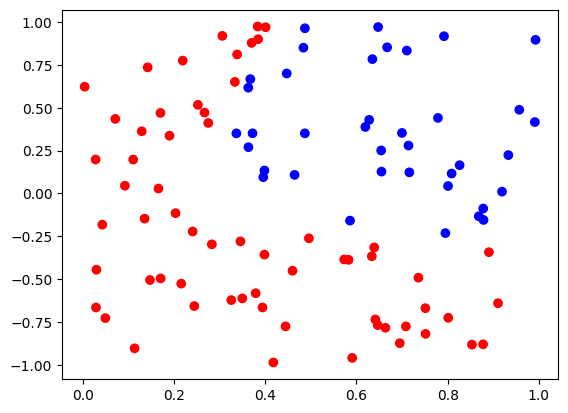

In [243]:
# verify on test data:
x, y = np.transpose(vectors)
plt.scatter(x,y, c=['blue' if f(p) > 0 else 'red' if f(p) < 0 else 'black 'for p in vectors])
plt.show()

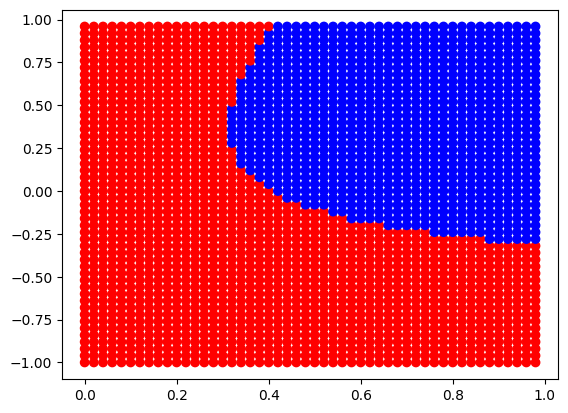

In [244]:
M = 50
x, y = (np.array([[i]*M for i in range(M)])/M).flatten(), 2*np.array(list(range(M))*M)/M - 1
plt.scatter(x,y, c=['blue' if f((x[i],y[i])) > 0 else 'red' if f((x[i],y[i])) < 0 else 'black 'for i in range(M*M)])
plt.show()

Classical SVM Tests:

In [248]:
N = 100
C = 1
gamma = 1e-1
vectors = np.transpose([np.random.rand(N), 2*np.random.rand(N)-1])
labels = [2*int(y>0 and x>0.5)-1 for x,y in vectors]
#objective, alpha, g = cSVM(vectors, labels, C, kernel=gauss_kernel(gamma), solver='CPLEX', time_limit=10)
objective, alpha, g = cSVM(vectors, labels, C, kernel=linear_kernel(1), solver='CPLEX', time_limit=10)

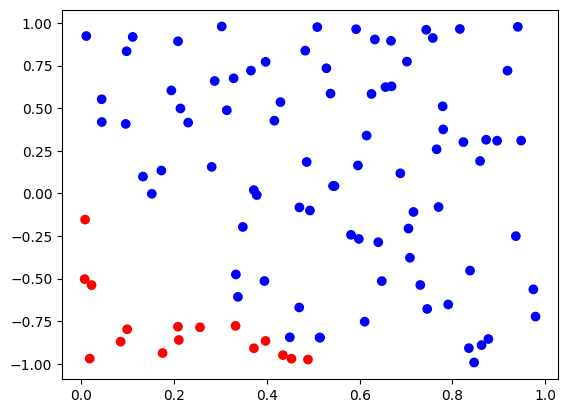

In [249]:
# verify on test data:
x, y = np.transpose(vectors)
plt.scatter(x,y, c=['blue' if g(p) > 0 else 'red' if g(p) < 0 else 'black 'for p in vectors])
plt.show()

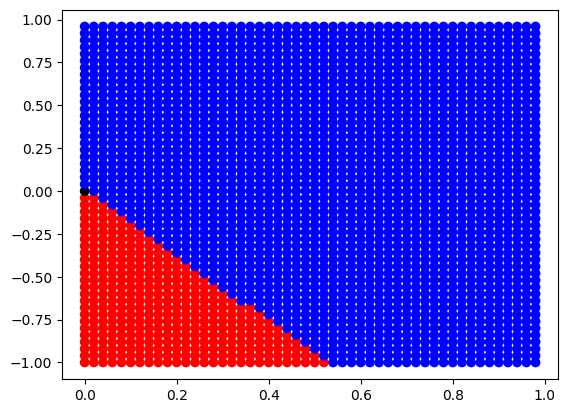

In [256]:
M = 50
x, y = (np.array([[i]*M for i in range(M)])/M).flatten(), 2*np.array(list(range(M))*M)/M - 1
plt.scatter(x,y, c=['blue' if g((x[i],y[i])) > 0 else 'red' if g((x[i],y[i])) < 0 else 'black' for i in range(M*M)])
plt.show()